In [1]:
import sys
sys.path.append('../')

import warnings
warnings.filterwarnings("ignore")

from utils import *
from tqdm.auto import tqdm
import numpy as np
import pickle
import os
from experiment import unpack_and_dequantize

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15,
                     "figure.dpi" : 100, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": False, 
                     "axes.axisbelow" : True,
                     "figure.figsize":(8,6),
                     "mathtext.fontset":"cm",
                     "xtick.labelsize": 14,
                     "ytick.labelsize": 14,
                     "axes.labelsize": 16, 
                     "legend.fontsize": 13.5})
plt.rc("text", usetex=False)
plt.rc("font", family="serif")

In [2]:
amplitude_files = {
    "eut": "../eut_dominant_frequencies_amplitudes.pickle",
    "pt": "../pt_dominant_frequencies_amplitudes.pickle",
    "cpt": "../cpt_dominant_frequencies_amplitudes.pickle"
}

models = ["eut", "pt", "cpt"]
data_storage = {m: [] for m in models}
N = 200

for model in models:
    dir_path = os.path.join("..", model) # Adjust path
    f_names = [f for f in os.listdir(dir_path)]
    
    # Load amplitudes for this model if available
    amps = []
    if amplitude_files[model] and os.path.exists(amplitude_files[model]):
        with open(amplitude_files[model], "rb") as f:
            raw_amps = pickle.load(f) 
            amps = [np.mean(x["amplitudes"]) for x in raw_amps]

    # Load simulation states
    print(f"Processing {model.upper()}...")
    for idx, f_name in enumerate(tqdm(f_names)):
        if idx >= len(amps): break
        try:
            with open(os.path.join(dir_path, f_name), "rb") as f:
                res = pickle.load(f)
            
            # Get last step
            w = unpack_and_dequantize(res["wealth"][:,-1], N)
            h = unpack_and_dequantize(res["health"][:,-1], N)
            
            # Store tuple: (w_array, h_array, scalar_amplitude)
            data_storage[model].append((w, h, amps[idx]))
            
        except Exception as e:
            print(f"Error {f_name}: {e}")

Processing EUT...


  0%|          | 0/1024 [00:00<?, ?it/s]

Processing PT...


  0%|          | 0/1024 [00:00<?, ?it/s]

Processing CPT...


  0%|          | 0/1024 [00:00<?, ?it/s]

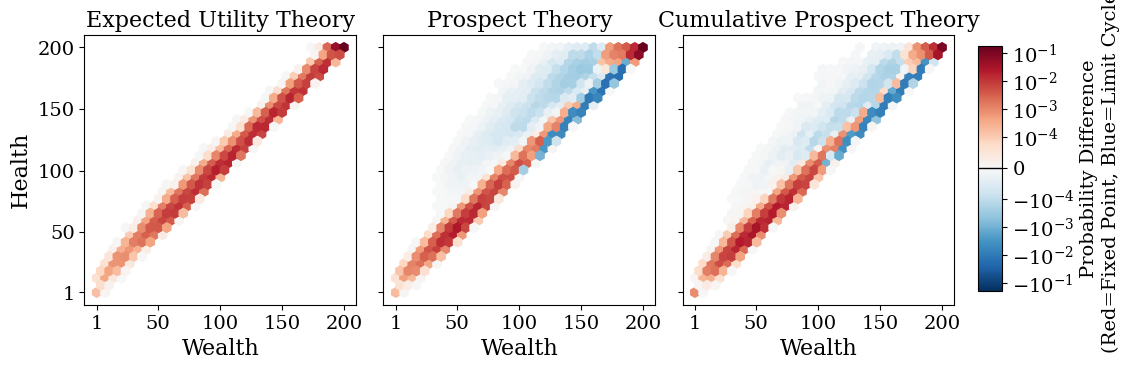

In [ ]:
num_bins = 30
AMP_THRESHOLD = 5

# 1. PRE-CALCULATE DATA & LIMITS
max_abs_diff = 0.0
diff_data_cache = []

for model in models:
    all_items = data_storage[model]
    total_points = sum(len(item[0]) for item in all_items)
    if total_points == 0: total_points = 1
    
    w_combined = []
    h_combined = []
    weights_combined = []
    
    # Positive Weights (Attractors)
    filt_attractors = [item for item in all_items if item[2] < AMP_THRESHOLD]
    if filt_attractors:
        w = np.concatenate([item[0] for item in filt_attractors])
        h = np.concatenate([item[1] for item in filt_attractors])
        w_combined.append(w)
        h_combined.append(h)
        weights_combined.append(np.ones_like(w) / total_points)

    # Negative Weights (Cycles)
    filt_cycles = [item for item in all_items if item[2] >= AMP_THRESHOLD]
    if filt_cycles:
        w = np.concatenate([item[0] for item in filt_cycles])
        h = np.concatenate([item[1] for item in filt_cycles])
        w_combined.append(w)
        h_combined.append(h)
        weights_combined.append(np.ones_like(w) * (-1.0 / total_points))

    if w_combined:
        full_w = np.concatenate(w_combined)
        full_h = np.concatenate(h_combined)
        full_weights = np.concatenate(weights_combined)
        
        # Estimate range
        H, _, _ = np.histogram2d(full_w, full_h, bins=num_bins, 
                                 range=[[0, N], [0, N]], weights=full_weights)
        
        current_max = np.max(np.abs(H))
        if current_max > max_abs_diff:
            max_abs_diff = current_max
            
        diff_data_cache.append((full_w, full_h, full_weights))
    else:
        diff_data_cache.append(None)

if max_abs_diff == 0: max_abs_diff = 0.1


norm_diff = mcolors.SymLogNorm(linthresh=0.0001, linscale=1, 
                               vmin=-max_abs_diff, vmax=max_abs_diff, base=10)


# 2. PLOTTING
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharex=True, sharey=True)
titles = ["EUT", "PT", "CPT"]

plt.subplots_adjust(right=0.85, wspace=0.1)

for i, model in enumerate(models):
    ax = axes[i]
    data = diff_data_cache[i]
    
    if data is not None:
        w, h, weights = data
        
        hb = ax.hexbin(w, h, 
                       C=weights,
                       reduce_C_function=np.sum,
                       gridsize=num_bins, 
                       cmap='RdBu_r', 
                       norm=norm_diff,  # <--- Applied here
                       extent=[1, N, 1, N], 
                       mincnt=None)
    else:
        ax.text(100, 100, "No Data", ha='center', va='center')
        ax.set_facecolor("#f0f0f067")

    ax.set_title(f"{titles[i]}", fontsize=16)
    ax.set_xlabel("Wealth")

axes[0].set_ylabel("Health")

# --- SET TICKS ---
ticks = [1, 50, 100, 150, 200]
for ax in axes.flat:
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

# 3. CREATE COLORBAR
sm = plt.cm.ScalarMappable(cmap='RdBu_r', norm=norm_diff)
sm.set_array([]) 

cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7]) 
cb = fig.colorbar(sm, cax=cbar_ax)
cb.set_label('Probability Difference\n(Red=Fixed Point, Blue=Limit Cycle)', fontsize=14)
cb.ax.hlines(0, -1, 1, colors='k', linewidth=1) 
plt.savefig("../figures/attractor_probability_difference.pdf", bbox_inches="tight")
plt.show()